# **Taller: Clustering Espectral con Función Q de Modularidad**

**Estudiante: Francisco Salamanca**

**Mineria de datos: Universidad Nacional de Colombia**

**2025-1**

----


### **Objetivo**
Implementar y analizar los algoritmos de clustering espectral propuestos por White & Smyth, comparando sus enfoques y analizando la función de modularidad Q.

Tener claro que es un analisis exploratorio, donde sus resultados pueden ser usados para modelar o revisar asociaciones estadisticas entre los clusters generados.

### **Resumen:**

Clustering espectral, es un metodo de clustering donde:

- Se construye un grafo, los nodos son los puntos de datos y las aristas son similitud entre ellos.

- Se calcula una matriz de laplace del grafo, o particion que maximice la modularidad

- extrae autovectores (PC del grafo)

- Aplica un algoritmo de clustering para hacer los clusters

Si se anade una funcion de modularidad, se detectaran comunidades en los grafos.


#### **Como Funciona**

Spectral- 1 = se basa en la idea de que los autovectores de una matriz relacionada con el grafo contienen información sobre la estructura de las comunidades del grafo. Posteriormente de  realiza el clustering con kmeans.

Spectral - 2 =  utiliza un enfoque de división recursiva o greedy para encontrar comunidades, también basado en el embedding espectral (autovectores que contienen info sobre la estructura del grafo.)

La diferencia de Spectral-1 es que Spectral-2 construye la partición de forma incremental, dividiendo clústeres uno por uno y aceptando solo las divisiones que mejoran la modularidad. Este enfoque es más rápido que probar todos los valores de K (clusters) como Spectral-1, pero es propenso a quedarse atrapado en mínimos locales, ya que solo considera mejoras inmediatas en Q.


#### **Modularidad:**

metrica que mide que tan bien esta esta dividido un grafo en comunidades.

ventajas:

- se maximiza la estructura real de interaccion (ej. interaccion prot-prot)

- se busca alta modularidad (Comunidades internas densas, mientras las externas debiles)

- deteccion de clusters de tamano cambiante


### **Ejemplos, posibles aproximaciones:**

- Deteccion de modulos de coexpresion
- Agrupamiento de pacientes segun sintomas y biomarcadores
- subtipificacion de tumores mediante redes geneticas
- deteccion de comunidades funcionales
- deteccion de subtipos de IBD.










## **Parte 1: Configuración Inicial**


Nodos: 30, Aristas: 95


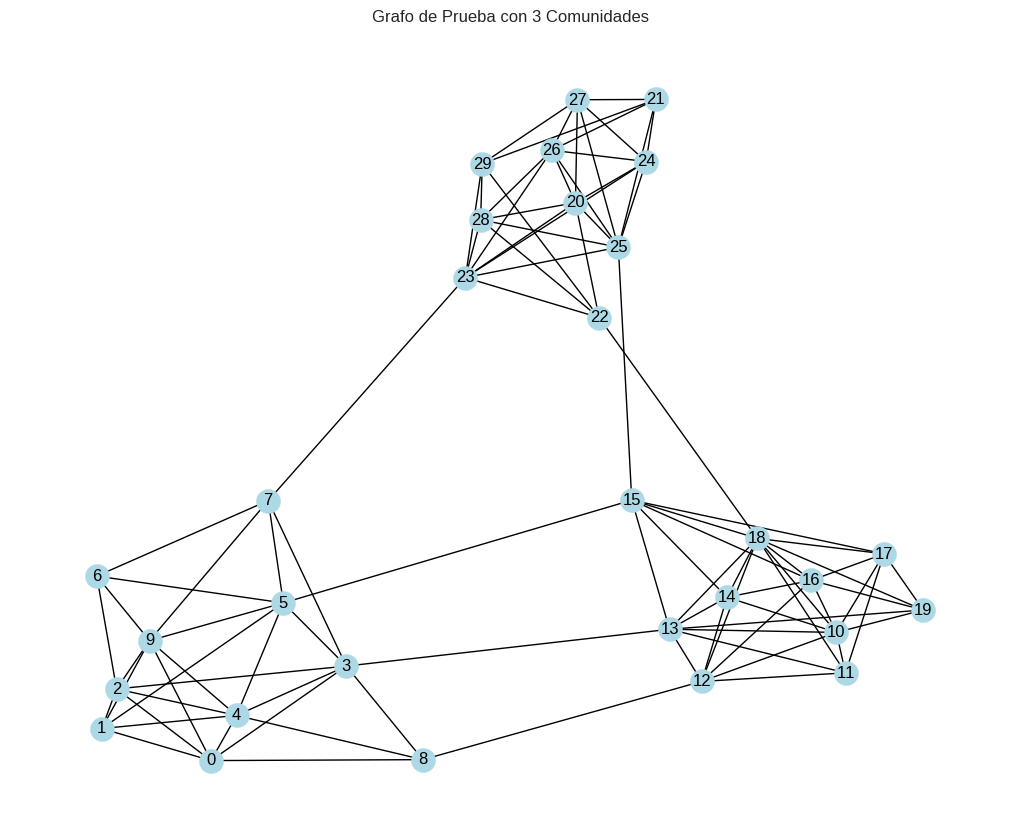

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import pandas as pd
from scipy.sparse.linalg import eigs
import warnings
warnings.filterwarnings('ignore')

# Configuración para gráficos
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8')

# Creamos un grafo con estructura de comunidades clara
G = nx.Graph()

np.random.seed(42)  # Para reproducibilidad

# Comunidad 1: Nodos 0-9 (densamente conectados)
for i in range(10):
    for j in range(i+1, 10):
        if np.random.random() > 0.3:  # 70% probabilidad de conexión interna
            G.add_edge(i, j)

# Comunidad 2: Nodos 10-19
for i in range(10, 20):
    for j in range(i+1, 20):
        if np.random.random() > 0.3:
            G.add_edge(i, j)

# Comunidad 3: Nodos 20-29
for i in range(20, 30):
    for j in range(i+1, 30):
        if np.random.random() > 0.3:
            G.add_edge(i, j)

# Conexiones entre comunidades (pocas)
inter_edges = [(5, 15), (15, 25), (8, 12), (18, 22), (3, 13), (23, 7)]
G.add_edges_from(inter_edges)

print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")

# Visualizar el grafo
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color='lightblue', node_size=300, with_labels=True)
plt.title("Grafo de Prueba con 3 Comunidades")
plt.show()


## Parte 2: Implementación de la Función Q

### **EJERCICIO 1**: Completar la función de modularidad Q

In [6]:
def calculate_modularity_Q(G, partition):
    """
    Calcula la función de modularidad Q para una partición dada

    Q = Σ[A(Vc,Vc)/A(V,V) - (A(Vc,V)/A(V,V))²]

    Args:
        G: grafo de NetworkX
        partition: lista de listas, cada sublista contiene los nodos de un cluster

    Returns:
        Q: valor de modularidad
    """
    # Obtener matriz de adyacencia
    A = nx.adjacency_matrix(G).toarray()
    n = len(G.nodes())

    # Calcular A(V,V) - suma total de pesos de aristas
    total_edges = G.number_of_edges()*2 # for undirected graphs, it's just the number of edges

    Q = 0

    # TODO: Completar el cálculo de Q
    # Para cada cluster c en la partición:
    for cluster in partition:
        if len(cluster) == 0:
            continue

        # A(Vc,Vc): suma de aristas dentro del cluster
        within_cluster = 0
        # TODO: Calcular conexiones internas del cluster
        # PISTA: usar A[i,j] para nodos i,j en el cluster
        for i in cluster:
            for j in cluster:
                if i != j:
                    within_cluster += A[i, j]

        # A(Vc,V): suma de aristas conectadas al cluster
        # TODO: Calcular el grado total del cluster
        # PISTA: sumar todos los grados de nodos en el cluster
        cluster_degree = sum([G.degree(node) for node in cluster])

        # Contribución al Q
        # TODO: Implementar la fórmula Q += ...
        if total_edges > 0: # Avoid division by zero
             Q += (within_cluster / (2 * total_edges)) - ((cluster_degree / (2 * total_edges)) ** 2)


    return Q

# Probar con partición verdadera
true_partition = [list(range(10)), list(range(10, 20)), list(range(20, 30))]
print(f"Q para partición verdadera: {calculate_modularity_Q(G, true_partition):.3f}")

Q para partición verdadera: 0.385



## Parte 3: Algoritmo Spectral-1

### **EJERCICIO 2**: Implementar matriz de transición y embedding

In [8]:
def spectral_embedding(G, K):
    """
    Crear el embedding espectral del grafo
    """
    # Obtener matriz de adyacencia
    A = nx.adjacency_matrix(G).toarray()

    # Matriz de grados D
    degrees = np.array([G.degree(node) for node in G.nodes()])
    D = np.diag(degrees)

    # TODO: Crear matriz de transición M = D^(-1) * W
    # PISTA: usar np.linalg.inv() o np.linalg.pinv() para la inversa
    # Handle nodes with degree 0
    D_inv = np.linalg.pinv(D)
    M = np.dot(D_inv, A)

    # Calcular K-1 eigenvectores principales (excluyendo el trivial)
    eigenvals, eigenvecs = eigs(M, k=K, which='LR')

    # Ordenar por eigenvalues (mayor a menor)
    idx = eigenvals.argsort()[::-1]
    eigenvecs = eigenvecs[:, idx]

    # Remover el eigenvector trivial (todos unos)
    U_K = eigenvecs[:, 1:K]  # Tomar K-1 eigenvectores

    return U_K.real

def spectral_algorithm_1(G, max_K=10):
    """
    Algoritmo Spectral-1: Prueba todos los valores de k
    """
    # Obtener embedding
    U_K = spectral_embedding(G, max_K)

    best_Q = -1
    best_k = 1
    best_partition = None
    results = []

    for k in range(2, max_K + 1):

        cols_needed = min(k-1, U_K.shape[1])
        U_k = U_K[:, :cols_needed]
        U_k_normalized = normalize(U_k, norm='l2', axis=1)

        # Aplicar k-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(U_k_normalized)

        # Convertir a formato de partición
        partition = [[] for _ in range(k)]
        for node, label in enumerate(labels):
            partition[label].append(node)

        # Calcular Q
        Q = calculate_modularity_Q(G, partition)
        results.append((k, Q))

        if Q > best_Q:
            best_Q = Q
            best_k = k
            best_partition = partition

        print(f"k={k}, Q={Q:.3f}")

    return best_k, best_Q, best_partition, results

# Ejecutar algoritmo
print("=== ALGORITMO SPECTRAL-1 ===")
best_k1, best_Q1, best_partition1, results1 = spectral_algorithm_1(G, max_K=8)
print(f"\nMejor resultado: k={best_k1}, Q={best_Q1:.3f}")


=== ALGORITMO SPECTRAL-1 ===
k=2, Q=0.345
k=3, Q=0.385
k=4, Q=0.348
k=5, Q=0.304
k=6, Q=0.234
k=7, Q=0.210
k=8, Q=0.177

Mejor resultado: k=3, Q=0.385


## Parte 4: Algoritmo Spectral-2 y Análisis de Mínimos Locales

### **EJERCICIO 3**: Analizar problemas de mínimos locales

In [9]:
def spectral_algorithm_2(G, max_K=10, initialization='random'):
    """
    Algoritmo Spectral-2: Búsqueda greedy con divisiones recursivas

    Args:
        initialization: 'random', 'kmeans++', 'degree_based'
    """
    U_K = spectral_embedding(G, max_K)

    # TODO: Implementar diferentes estrategias de inicialización
    if initialization == 'random':
        # Inicialización aleatoria estándar
        initial_partition = [list(G.nodes())]
    elif initialization == 'degree_based':
        # TODO: Inicializar basado en grados de nodos
        # Separar nodos de alto y bajo grado
        nodes = list(G.nodes())
        degrees = [G.degree(node) for node in nodes]
        median_degree = np.median(degrees)

        high_degree = [node for node in nodes if G.degree(node) >= median_degree]
        low_degree = [node for node in nodes if G.degree(node) < median_degree]
        initial_partition = [high_degree, low_degree] if len(high_degree) > 0 and len(low_degree) > 0 else [nodes]
    else:  # kmeans++
        initial_partition = [list(G.nodes())]

    current_partition = initial_partition
    best_Q = calculate_modularity_Q(G, current_partition)
    k = len(current_partition)

    print(f"Inicialización {initialization}: Q inicial = {best_Q:.3f}")

    improved = True
    iteration = 0

    while improved and k < max_K:
        improved = False
        iteration += 1
        print(f"\n--- Iteración {iteration} ---")

        for i, cluster in enumerate(current_partition):
            if len(cluster) <= 1:
                continue

            # Intentar dividir el cluster i
            cluster_indices = cluster

            # Obtener embedding para este cluster
            cols_needed = min(k-1, U_K.shape[1]) if k > 1 else 1
            U_k = U_K[:, :cols_needed] if k > 1 else U_K[:, :1]
            U_cluster = U_k[cluster_indices] if U_k.shape[0] > max(cluster_indices) else U_k
            # Manejar caso donde el embedding es muy pequeño
            if U_cluster.shape[0] < len(cluster_indices):
                # Crear embedding sintético
                U_cluster = np.random.randn(len(cluster_indices), U_k.shape[1])

            U_cluster_norm = normalize(U_cluster, norm='l2', axis=1)


            # TODO: Aplicar k-means con k=2 al cluster
            if len(cluster) >= 2:
                kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
                sub_labels = kmeans.fit_predict(U_cluster_norm)

                # Crear nueva partición
                new_cluster1 = [cluster_indices[j] for j in range(len(cluster_indices)) if sub_labels[j] == 0]
                new_cluster2 = [cluster_indices[j] for j in range(len(cluster_indices)) if sub_labels[j] == 1]

                if len(new_cluster1) == 0 or len(new_cluster2) == 0:
                    continue

                # Probar nueva partición
                test_partition = current_partition.copy()
                test_partition[i] = new_cluster1
                test_partition.append(new_cluster2)

                new_Q = calculate_modularity_Q(G, test_partition)

                print(f"  Dividir cluster {i} (tamaño {len(cluster)}): Q = {new_Q:.3f}")

                # TODO: Aceptar o rechazar la división
                if new_Q > best_Q:
                    current_partition = test_partition
                    best_Q = new_Q
                    k += 1
                    improved = True
                    print(f"    ✓ División aceptada! Nuevo Q = {best_Q:.3f}")
                    break  # Only one split per iteration
                else:
                    print(f"    ✗ División rechazada (Q actual = {best_Q:.3f})")

    return len(current_partition), best_Q, current_partition

# Probar diferentes inicializaciones
print("=== ALGORITMO SPECTRAL-2 ===")
print("\n1. Inicialización aleatoria:")
k2_rand, Q2_rand, partition2_rand = spectral_algorithm_2(G, max_K=8, initialization='random')

print("\n2. Inicialización basada en grados:")
k2_degree, Q2_degree, partition2_degree = spectral_algorithm_2(G, max_K=8, initialization='degree_based')

print(f"\nComparación de inicializaciones:")
print(f"Aleatoria: k={k2_rand}, Q={Q2_rand:.3f}")
print(f"Por grados: k={k2_degree}, Q={Q2_degree:.3f}")

=== ALGORITMO SPECTRAL-2 ===

1. Inicialización aleatoria:
Inicialización random: Q inicial = 0.250

--- Iteración 1 ---
  Dividir cluster 0 (tamaño 30): Q = 0.345
    ✓ División aceptada! Nuevo Q = 0.345

--- Iteración 2 ---

2. Inicialización basada en grados:
Inicialización degree_based: Q inicial = 0.153

--- Iteración 1 ---
  Dividir cluster 0 (tamaño 21): Q = 0.219
    ✓ División aceptada! Nuevo Q = 0.219

--- Iteración 2 ---
  Dividir cluster 0 (tamaño 14): Q = 0.241
    ✓ División aceptada! Nuevo Q = 0.241

--- Iteración 3 ---
  Dividir cluster 0 (tamaño 6): Q = 0.239
    ✗ División rechazada (Q actual = 0.241)
  Dividir cluster 1 (tamaño 9): Q = 0.242
    ✓ División aceptada! Nuevo Q = 0.242

--- Iteración 4 ---
  Dividir cluster 0 (tamaño 6): Q = 0.240
    ✗ División rechazada (Q actual = 0.242)
  Dividir cluster 1 (tamaño 5): Q = 0.244
    ✓ División aceptada! Nuevo Q = 0.244

--- Iteración 5 ---
  Dividir cluster 0 (tamaño 6): Q = 0.224
    ✗ División rechazada (Q actual = 


## Parte 5: Análisis y Comparación

### **EJERCICIO 4**: Analizar resultados y mínimos locales

=== RESUMEN DE RESULTADOS ===
Partición verdadera: k=3, Q=0.385
Spectral-1: k=3, Q=0.385
Spectral-2 (aleatorio): k=2, Q=0.345
Spectral-2 (por grados): k=7, Q=0.245


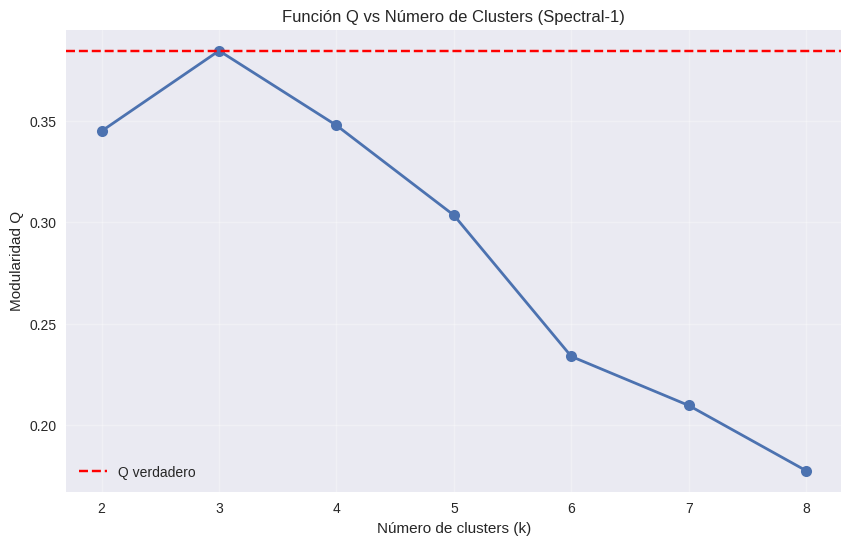

In [10]:
# Comparar todos los resultados
print("=== RESUMEN DE RESULTADOS ===")
print(f"Partición verdadera: k=3, Q={calculate_modularity_Q(G, true_partition):.3f}")
print(f"Spectral-1: k={best_k1}, Q={best_Q1:.3f}")
print(f"Spectral-2 (aleatorio): k={k2_rand}, Q={Q2_rand:.3f}")
print(f"Spectral-2 (por grados): k={k2_degree}, Q={Q2_degree:.3f}")

# Visualizar curva Q vs k para Spectral-1
plt.figure(figsize=(10, 6))
ks, Qs = zip(*results1)
plt.plot(ks, Qs, 'o-', linewidth=2, markersize=8)
plt.axhline(y=calculate_modularity_Q(G, true_partition), color='red', linestyle='--',
           label='Q verdadero')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Modularidad Q')
plt.title('Función Q vs Número de Clusters (Spectral-1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Preguntas de análisis

1. ¿Por qué Spectral-2 puede quedarse atrapado en mínimos locales?

Por que usa un enfoque greedy, comenzando con una particion inicial y luego intentando mejorar la mdularidad dividiendo los clusteres. A pesar de esto, al solo dividir un cluster a la vez, y solo aceptar la divisio si aumenta la modularidad, podria llevar a un estado qie no haya divisiones que mejoren la modlaridad .

2. ¿Cuál algoritmo es más robusto para encontrar el óptimo global?

Spectral 1, pues encontro un optimo de 0.385, ademas que spectral 2 es mas propenso a minimos locales, porque sus decisiones en cada paso (qué clúster dividir) se basan solo en la mejora inmediata de la modularidad, obteniendo modularidades mas bajas.


3. ¿Qué significa que Q = 0.7? ¿Es mejor que Q = 0.3?

un Q de 0.7 indica una particion con una estructura de comunidad fuerte, donde la densidad de aristas es mayor de lo esperado.

por lo que un Q mas alto es mejor, indicanto una estructura de comunidad mas clara (con aristas densas)
